In [1]:
import pandas as pd
import statsmodels as st
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
CustomerData = pd.read_excel('datasets/test3.xlsx')

In [56]:
CustomerData.head()

,month,LOB,patner type,product category,Sale type,deal size,order qty,Discount,list margin,List revenue,cost price,selling price,cmp price
0,2015-M10,CSB,V,XYZ 11,APOS,Small,1,0.140000,0.285679,0.00,0.000,0.0,0
1,2015-M10,CSB,V,XYZ 11,APOS,Small,1,0.125005,0.186930,56.04,102.495,173.2,0
2,2015-M10,CSB,V,XYZ 11,APOS,Small,1,0.075005,0.184192,0.00,0.000,0.0,0
3,2015-M10,CSB,V,XYZ 11,POS,Small,1,0.000000,0.183198,30.09,47.495,63.0,0
4,2015-M10,CSB,V,XYZ 11,POS,Small,1,0.000000,0.171554,0.00,0.000,0.0,0


In [57]:
CustomerData.describe()

,order qty,Discount,list margin,List revenue,cost price,selling price,cmp price
count,40204.000000,4.019200e+04,4.019200e+04,40204.000000,40204.000000,40204.000000,40204.000000
mean,2.864839,2.626222e+09,2.976385e+09,56.822743,193.508829,212.947811,0.074947
std,5.379440,5.265035e+11,5.967040e+11,74.338355,298.988724,339.290674,0.222483
min,1.000000,-7.733614e+01,-3.588307e+00,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000025e-01,2.280285e-01,11.600000,37.495000,0.000000,0.000000
50%,1.000000,1.400020e-01,3.321395e-01,41.295000,102.495000,130.400000,0.000000
75%,2.000000,2.077442e-01,3.799081e-01,73.220000,242.495000,267.360000,0.000000
max,115.000000,1.055531e+14,1.196269e+14,929.525000,4004.995000,4830.210000,1.080000


In [58]:
CustomerData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40204 entries, 0 to 40203
Data columns (total 13 columns):
month                40204 non-null object
LOB                  40204 non-null object
patner type          40204 non-null object
product category     40204 non-null object
Sale type            40204 non-null object
deal size            40204 non-null object
order qty            40204 non-null int64
Discount             40192 non-null float64
list margin          40192 non-null float64
List revenue         40204 non-null float64
cost price           40204 non-null float64
selling price        40204 non-null float64
cmp price            40204 non-null float64
dtypes: float64(6), int64(1), object(6)
memory usage: 4.3+ MB


In [59]:
CustomerData.corr()

,order qty,Discount,list margin,List revenue,cost price,selling price,cmp price
order qty,1.000000,-0.000802,-0.000802,-0.053086,-0.079325,-0.056973,-0.069551
Discount,-0.000802,1.000000,1.000000,-0.003814,-0.003229,-0.003132,-0.001680
list margin,-0.000802,1.000000,1.000000,-0.003814,-0.003229,-0.003132,-0.001680
List revenue,-0.053086,-0.003814,-0.003814,1.000000,0.947201,0.915462,0.120854
cost price,-0.079325,-0.003229,-0.003229,0.947201,1.000000,0.915316,0.241674
selling price,-0.056973,-0.003132,-0.003132,0.915462,0.915316,1.000000,0.152687
cmp price,-0.069551,-0.001680,-0.001680,0.120854,0.241674,0.152687,1.000000


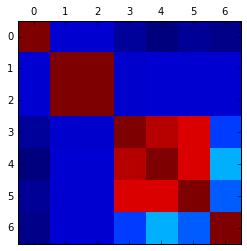

In [60]:
_corr = CustomerData.corr()
plt.matshow(_corr)
#plt.legend(_corr.columns)
#plt.plot(CustomerData.corr())

# As of now discount looks highly correlated only with 'list margin'
#### But are there more trends/relations?
* Let's treat missing values, outliers(if any), highly-influencing points if any.
* After treat/cleaning data - let's see if there are more trends visible

In [76]:
# Remove missing values from Discount (they are very few)
_tmp = CustomerData[(pd.isnull(CustomerData['Discount']) == True)].shape
print ("Missing values in Discount are: {}".format(_tmp))
CustomerDataNoMissing = CustomerData[pd.isnull(CustomerData['Discount']) == False]

Missing values in Discount are: (12, 13)


In [77]:
# Check another missing values too:
def printmissingValues(x):
    print(x[pd.isnull(x) == True].shape)
CustomerDataNoMissing.apply(lambda x: printmissingValues(x), axis=0)

(0L,)
(0L,)
(0L,)
(0L,)
(0L,)
(0L,)
(0L,)
(0L,)
(0L,)
(0L,)
(0L,)
(0L,)
(0L,)


month                None
LOB                  None
patner type          None
product category     None
Sale type            None
deal size            None
order qty            None
Discount             None
list margin          None
List revenue         None
cost price           None
selling price        None
cmp price            None
dtype: object

In [78]:
def getUpperAndLowerOutlierThreshold(data):
    q75, q25 = np.percentile(data, [75 ,25])
    iqr = q75 - q25
    upperOutlier = q75 + iqr*1.5
    lowerOutlier = q25 - iqr*1.5
    return upperOutlier,lowerOutlier

def removeOutliers(data,i):
    _upperOutlier,_lowerOutlier = getUpperAndLowerOutlierThreshold(data[i])
    return data[((data[i] < _upperOutlier) & (data[i] > _lowerOutlier ))]


In [79]:
# Let's select features
categoricalFeatures = ['product category ', 'patner type',  'Sale type','deal size']
numericfeatures = ['order qty', 'Discount']

In [80]:
CustomerDataTemp = CustomerDataNoMissing

In [81]:
for i in numericfeatures:
    upperOutlier,lowerOutlier = getUpperAndLowerOutlierThreshold(CustomerDataTemp[i])
    print("="*80)
    print (upperOutlier,lowerOutlier)
    print (i)
    
    totalLen = CustomerDataTemp.shape[0]
    afterRemovingOutliers = (CustomerDataTemp[((CustomerDataTemp[i] < upperOutlier) & 
                                           (CustomerDataTemp[i] > lowerOutlier ))].shape)[0]
    print (afterRemovingOutliers)
    percentageOfOutliers = ( ((totalLen - afterRemovingOutliers)*100) / totalLen)
    print ("Total={}  #Outlier={} Outliers={} %".format(totalLen,totalLen - afterRemovingOutliers,percentageOfOutliers))
    print ()
    #Remove outliers


print (CustomerDataTemp.shape)
CustomerDataRemovedMissingAndOL = removeOutliers(CustomerDataTemp,'Discount')
print (CustomerDataRemovedMissingAndOL.shape)

(3.5, -0.5)
order qty
33330
Total=40192  #Outlier=6862 Outliers=17 %
()
(0.36935660122165215, -0.061609896064030278)
Discount
39346
Total=40192  #Outlier=846 Outliers=2 %
()
(40192, 13)
(39346, 13)


* In Discount column, if we see:  upper and lower quartile value .36 and .06; and outliers are 2%. These outliers doesn't look like outliers, but indicates different segment of data.

* Let's remove very few highly influencing points as of now and see more trends in data if visible

# Outlier analysis by percentage indicates presence of few segmentation
* Removing outliers s not good idea.
* Let's see if removing high influential points help

In [66]:
_a = CustomerDataTemp.sort_values(by=['Discount'],ascending=False)['Discount'].head(10)
_b = CustomerDataTemp.sort_values(by=['Discount'],ascending=True)['Discount'].head(10)

print (_a, _b)

(20754    1.055531e+14
24584    6.400000e+00
954      3.857823e+00
2461     1.796064e+00
38687    9.166667e-01
38038    8.544500e-01
15273    8.214286e-01
37651    7.883352e-01
15484    7.500000e-01
4122     7.494690e-01
Name: Discount, dtype: float64, 34579   -77.336141
27465   -19.865204
35974   -10.915917
15871    -4.800000
13468    -3.019996
33254    -2.729376
11328    -2.699969
36953    -2.031432
9264     -1.749969
30644    -1.553741
Name: Discount, dtype: float64)


# Caution : Never remove high influential points just like that: have some decision background

In [82]:
## Let's remove few highly influencing points
# Let's remove top 1 only.
_a = CustomerDataTemp.sort_values(by=['Discount'],ascending=False)['Discount'].head(1).values
#_b = CustomerDataTemp.sort_values(by=['Discount'],ascending=True)['Discount'].head(10).values
# Remove it : it is too high
#print (_a,_b)
CustomerDataTemp = CustomerDataTemp[-CustomerDataTemp['Discount'].isin(_a)]
#CustomerDataTemp = CustomerDataTemp[-CustomerDataTemp['Discount'].isin(_b)]



In [83]:
CustomerDataTemp.reset_index(drop=True,inplace=True)

In [84]:
CustomerDataTemp.head()

,month,LOB,patner type,product category,Sale type,deal size,order qty,Discount,list margin,List revenue,cost price,selling price,cmp price
0,2015-M10,CSB,V,XYZ 11,APOS,Small,1,0.140000,0.285679,0.00,0.000,0.0,0
1,2015-M10,CSB,V,XYZ 11,APOS,Small,1,0.125005,0.186930,56.04,102.495,173.2,0
2,2015-M10,CSB,V,XYZ 11,APOS,Small,1,0.075005,0.184192,0.00,0.000,0.0,0
3,2015-M10,CSB,V,XYZ 11,POS,Small,1,0.000000,0.183198,30.09,47.495,63.0,0
4,2015-M10,CSB,V,XYZ 11,POS,Small,1,0.000000,0.171554,0.00,0.000,0.0,0


In [85]:
columns = CustomerDataTemp.columns.values.tolist() 
#columns.remove('month')
#columns

In [86]:
#CustomerData[columns].apply(lambda x: x.unique(),axis=1)
'''
for i in columns:
    print("Column: {}".format(i))
    print(CustomerData[i].unique())
    print("*"*80)
'''

'\nfor i in columns:\n    print("Column: {}".format(i))\n    print(CustomerData[i].unique())\n    print("*"*80)\n'

In [87]:
#print (columns)
#a= CustomerData.groupby('patner type')
#a.corr()
#a.head()

In [88]:

#plt.matshow(a.corr())
#b = a.corr()
#b.columns

corrInVarGroupByCases = pd.DataFrame(columns=["GroupBy", "GroupBy Value", "Corr b/w Discount n List-Margin"])
    
columnsForGroupBy = ['LOB', 'patner type', 'product category ', 'Sale type', 'deal size', 'month']
tableIndex=0
for oindex,oval in enumerate(columnsForGroupBy):
    #f,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(10, 5))
    #axis = [ax1, ax2, ax3, ax4]
    columns_temp = columns
    a= CustomerData.groupby(oval)
    for index,val in enumerate(a.groups.keys()):
        b=a.get_group(val)
        #print("*"*80)
        #print ("Correlation under group: {} and group-value : {}".format(oval,val))
        corrInVarGroupByCases.loc[tableIndex] = [oval,val,b.corr()['Discount']['list margin']]
        tableIndex +=1
        #b.apply(lambda x: printCorrWithDiscount(x), axis=0)
        #axis[index].matshow(a.get_group(val).corr())
        #axis[index].set_title("{} : {}".format(oval,val))

print (corrInVarGroupByCases)
#pd.ExcelWriter("GroupByCorrMap.xlsx",corrInVarGroupByCases)
writer = pd.ExcelWriter('GroupByCorrMap.xlsx', engine='xlsxwriter')
# Convert the dataframe to an XlsxWriter Excel object.
corrInVarGroupByCases.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

              GroupBy         GroupBy Value  Corr b/w Discount n List-Margin
0                 LOB                    LI                         0.314219
1                 LOB         Uncategorized                         0.486983
2                 LOB  PrefeSmalled Account                         1.000000
3                 LOB                   CSB                         0.388722
4         patner type                Direct                         0.218392
5         patner type                     D                         0.559990
6         patner type                     V                         1.000000
7   product category             XYZ Others                         1.000000
8   product category          Client Others                         0.210744
9   product category                 XYZ 22                         0.191605
10  product category                 XYZ 11                         0.549675
11          Sale type                  APOS                         0.314887

# Few observations
## Best discount categories
* LOB : "PrefeSmalled Account"
* product category: "XYZ Others"
* Partner Type: "V" 
* Sale Type : "POS"
* Deal size : "Big"
* Month : Best : "September", second best : "July"
* ** There might be time-series kind of discount strategy also: like special months september (around Thanks giving), July (Probably US "School time" or "Independence day" time); But to say it for sure; we need across years of data


In [97]:
CustomerDataTemp.sort_values(by=['Discount'],ascending=False).head(10)



,month,LOB,patner type,product category,Sale type,deal size,order qty,Discount,list margin,List revenue,cost price,selling price,cmp price
24575,2016-M10,PrefeSmalled Account,Direct,XYZ 22,APOS,Small,2,6.400000,0.500000,323.395,1249.995,1504.045,0
953,2016-M06,CSB,Direct,XYZ 22,APOS,Small,2,3.857823,0.500000,81.115,424.995,471.265,0
2457,2016-M07,CSB,Direct,XYZ 11,APOS,Small,4,1.796064,0.842517,64.300,122.495,173.200,0
38674,2016-M08,Uncategorized,D,XYZ 11,POS,big,1,0.916667,0.750000,24.700,37.495,43.500,0
38025,2016-M04,Uncategorized,Direct,XYZ Others,APOS,Small,2,0.854450,0.504729,0.000,0.000,0.000,0
15266,2016-M01,LI,V,XYZ 11,POS,big,1,0.821429,0.857143,36.610,57.495,130.400,0
37638,2015-M11,Uncategorized,Direct,XYZ 11,APOS,big,2,0.788335,0.224959,64.300,122.495,173.200,0
15477,2016-M03,LI,Direct,XYZ 11,APOS,Small,3,0.750000,0.750000,30.090,47.495,63.000,0
4117,2015-M11,CSB,Direct,Client Others,APOS,Small,3,0.749469,0.500000,160.900,529.995,649.500,0
14789,2016-M03,LI,Direct,XYZ Others,POS,big,1,0.737805,0.506098,198.665,874.995,874.500,0


In [98]:
CustomerDataTemp.sort_values(by=['Discount'],ascending=True).head(10)

,month,LOB,patner type,product category,Sale type,deal size,order qty,Discount,list margin,List revenue,cost price,selling price,cmp price
34566,2016-M07,Uncategorized,D,XYZ 11,APOS,big,2,-77.336141,-3.588307,35.555,57.500,77.165,0.0
27454,2016-M07,PrefeSmalled Account,Direct,XYZ Others,APOS,big,5,-19.865204,0.403716,94.185,499.995,0.000,0.0
35961,2016-M03,Uncategorized,D,XYZ 11,POS,big,5,-10.915917,0.165309,0.000,0.000,0.000,0.0
15864,2015-M10,PrefeSmalled Account,V,XYZ Others,POS,big,1,-4.800000,0.201290,0.000,0.000,0.000,0.0
13461,2016-M06,LI,Direct,Client Others,POS,Small,1,-3.019996,0.249127,0.000,0.000,0.000,0.0
33241,2016-M06,Uncategorized,Direct,XYZ Others,APOS,Small,5,-2.729376,0.500000,0.000,0.000,0.000,0.0
11322,2016-M03,LI,Direct,XYZ 11,POS,big,1,-2.699969,0.174218,64.300,122.495,173.200,0.0
36940,2016-M09,Uncategorized,V,XYZ Others,POS,big,4,-2.031432,0.450484,11.600,90.000,101.250,0.5
9259,2016-M03,LI,Direct,XYZ 22,POS,big,1,-1.749969,0.326324,41.585,114.995,149.520,0.0
30632,2015-M12,PrefeSmalled Account,Direct,Client Others,APOS,Small,2,-1.553741,0.429582,20.810,36.495,20.000,0.0


In [99]:
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis=0)
    normalized_features = feature_matrix/norms
    return (normalized_features,norms)

In [104]:
# Let's do some categorization encoding : It may be not be most appropriate step, but let's just try
columns = CustomerDataTemp.columns.values.tolist()
columns.remove('Discount')

# Separate out Output : Discount
Discount = CustomerDataTemp['Discount']
CustomerDataTempEncoded = CustomerDataTemp[columns]

# Let's encode the factors
CustomerDataTempEncoded['month'] = pd.factorize(CustomerDataTempEncoded['month'])[0]
CustomerDataTempEncoded['patner type'] = pd.factorize(CustomerDataTempEncoded['patner type'])[0]
CustomerDataTempEncoded['LOB'] = pd.factorize(CustomerDataTempEncoded['LOB'])[0]
CustomerDataTempEncoded['Sale type'] = pd.factorize(CustomerDataTempEncoded['Sale type'])[0]
CustomerDataTempEncoded['deal size'] = pd.factorize(CustomerDataTempEncoded['deal size'])[0]
CustomerDataTempEncoded['product category '] = pd.factorize(CustomerDataTempEncoded['product category '])[0]



C:\Users\Dikshit\Anaconda4\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Dikshit\Anaconda4\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Dikshit\Anaconda4\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

In [114]:
pd.factorize(CustomerDataTemp['LOB'])[1].values.tolist()

[u'CSB', u'LI', u'PrefeSmalled Account', u'Uncategorized']

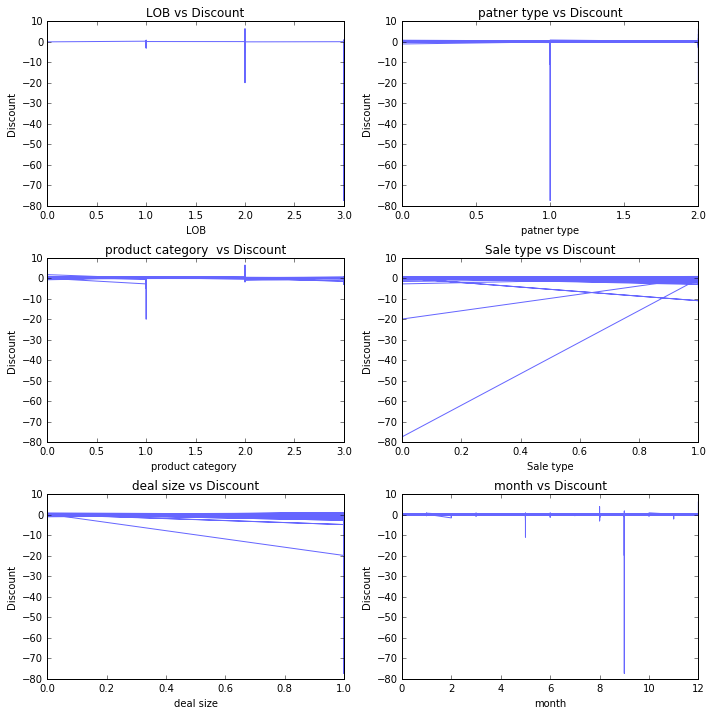

In [161]:
#columnsForGroupBy = ['LOB', 'patner type', 'product category ', 'Sale type', 'deal size', 'month']
f,((ax1,ax2),(ax3,ax4), (ax5,ax6))=plt.subplots(3,2,figsize=(10, 10))
axis = [ax1, ax2, ax3, ax4,ax5,ax6]
for oindex,oval in enumerate(columnsForGroupBy):
    axis[oindex].plot(CustomerDataTempEncoded[oval],Discount,alpha=.6)
    axis[oindex].set_title("{} vs Discount".format(oval))
    axis[oindex].set_xlabel(oval)
    axis[oindex].set_ylabel("Discount")
    #axis[oindex].legend(pd.factorize(CustomerDataTemp[oval])[1].values.tolist())
    #columns_temp = columns
    ##a= CustomerData.groupby(oval)
    '''
    for index,val in enumerate(a.groups.keys()):
        b=a.get_group(val)
        #print("*"*80)
        #print ("Correlation under group: {} and group-value : {}".format(oval,val))
        corrInVarGroupByCases.loc[tableIndex] = [oval,val,b.corr()['Discount']['list margin']]
        tableIndex +=1
        #b.apply(lambda x: printCorrWithDiscount(x), axis=0)
        #axis[index].matshow(a.get_group(val).corr())
        #axis[index].set_title("{} : {}".format(oval,val))
    '''
plt.tight_layout()
plt.savefig('CategoryVsDiscount.png', dpi=300)
    #print (corrInVarGroupByCases)

# Let's try Lasso to confirm same : which feature effects Discount most

In [117]:
CustomerDataTempEncoded.head(5)

,month,LOB,patner type,product category,Sale type,deal size,order qty,list margin,List revenue,cost price,selling price,cmp price
0,0,0,0,0,0,0,1,0.285679,0.00,0.000,0.0,0
1,0,0,0,0,0,0,1,0.186930,56.04,102.495,173.2,0
2,0,0,0,0,0,0,1,0.184192,0.00,0.000,0.0,0
3,0,0,0,0,1,0,1,0.183198,30.09,47.495,63.0,0
4,0,0,0,0,1,0,1,0.171554,0.00,0.000,0.0,0


In [123]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1,fit_intercept=False)
clf.fit(CustomerDataTempEncoded,Discount)

Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [124]:
clf.coef_.tolist()

[0.012845809525630004,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.00024659266272817937,
 0.0,
 0.0,
 0.00014799913807999777,
 0.0,
 0.0]

In [130]:
# Let's try different values of alpha
#print (CustomerDataTempEncoded.columns)
columnsAlphaTable = ['month', 'LOB', 'patner type', 'product category ', 'Sale type',
                     'deal size', 'order qty', 'list margin', 'List revenue',
                     'cost price ', 'selling price', 'cmp price', 'alpha']
#print (columnsAlphaTable)
saveAlphaVsCoeff = pd.DataFrame(columns=columnsAlphaTable)
#print (saveAlphaVsCoeff)
alphas = np.logspace(-20,2,30)
for index,alpha in enumerate(alphas):
    clf = linear_model.Lasso(alpha=alpha,fit_intercept=False)
    clf.fit(CustomerDataTempEncoded,Discount)  
    _coefList = clf.coef_.tolist()
    #print(_coefList)
    _coefList.append(alpha)
    #print (_coefList)
    saveAlphaVsCoeff.loc[index] = _coefList

Index([u'month', u'LOB', u'patner type', u'product category ', u'Sale type',
       u'deal size', u'order qty', u'list margin', u'List revenue',
       u'cost price ', u'selling price', u'cmp price'],
      dtype='object')
['month', 'LOB', 'patner type', 'product category ', 'Sale type', 'deal size', 'order qty', 'list margin', 'List revenue', 'cost price ', 'selling price', 'cmp price', 'alpha']
Empty DataFrame
Columns: [month, LOB, patner type, product category , Sale type, deal size, order qty, list margin, List revenue, cost price , selling price, cmp price, alpha]
Index: []


In [170]:

writer = pd.ExcelWriter('LassoAlphaVsCoeff.xlsx', engine='xlsxwriter')
# Convert the dataframe to an XlsxWriter Excel object.
saveAlphaVsCoeff.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()
saveAlphaVsCoeff

,month,LOB,patner type,product category,Sale type,deal size,order qty,list margin,List revenue,cost price,selling price,cmp price,alpha
0,-0.006695,-0.019834,-0.040546,-0.045596,0.001120,-0.001087,-0.000710,1.124676,0.000421,-0.000095,-4.323978e-06,-0.042812,1.000000e-20
1,-0.006695,-0.019834,-0.040546,-0.045596,0.001120,-0.001087,-0.000710,1.124676,0.000421,-0.000095,-4.323978e-06,-0.042812,5.736153e-20
2,-0.006695,-0.019834,-0.040546,-0.045596,0.001120,-0.001087,-0.000710,1.124676,0.000421,-0.000095,-4.323978e-06,-0.042812,3.290345e-19
3,-0.006695,-0.019834,-0.040546,-0.045596,0.001120,-0.001087,-0.000710,1.124676,0.000421,-0.000095,-4.323978e-06,-0.042812,1.887392e-18
4,-0.006695,-0.019834,-0.040546,-0.045596,0.001120,-0.001087,-0.000710,1.124676,0.000421,-0.000095,-4.323978e-06,-0.042812,1.082637e-17
5,-0.006695,-0.019834,-0.040546,-0.045596,0.001120,-0.001087,-0.000710,1.124676,0.000421,-0.000095,-4.323978e-06,-0.042812,6.210169e-17
6,-0.006695,-0.019834,-0.040546,-0.045596,0.001120,-0.001087,-0.000710,1.124676,0.000421,-0.000095,-4.323978e-06,-0.042812,3.562248e-16
7,-0.006695,-0.019834,-0.040546,-0.045596,0.001120,-0.001087,-0.000710,1.124676,0.000421,-0.000095,-4.323978e-06,-0.042812,2.043360e-15
8,-0.006695,-0.019834,-0.040546,-0.045596,0.001120,-0.001087,-0.000710,1.124676,0.000421,-0.000095,-4.323978e-06,-0.042812,1.172102e-14
9,-0.006695,-0.019834,-0.040546,-0.045596,0.001120,-0.001087,-0.000710,1.124676,0.000421,-0.000095,-4.323978e-06,-0.042812,6.723358e-14


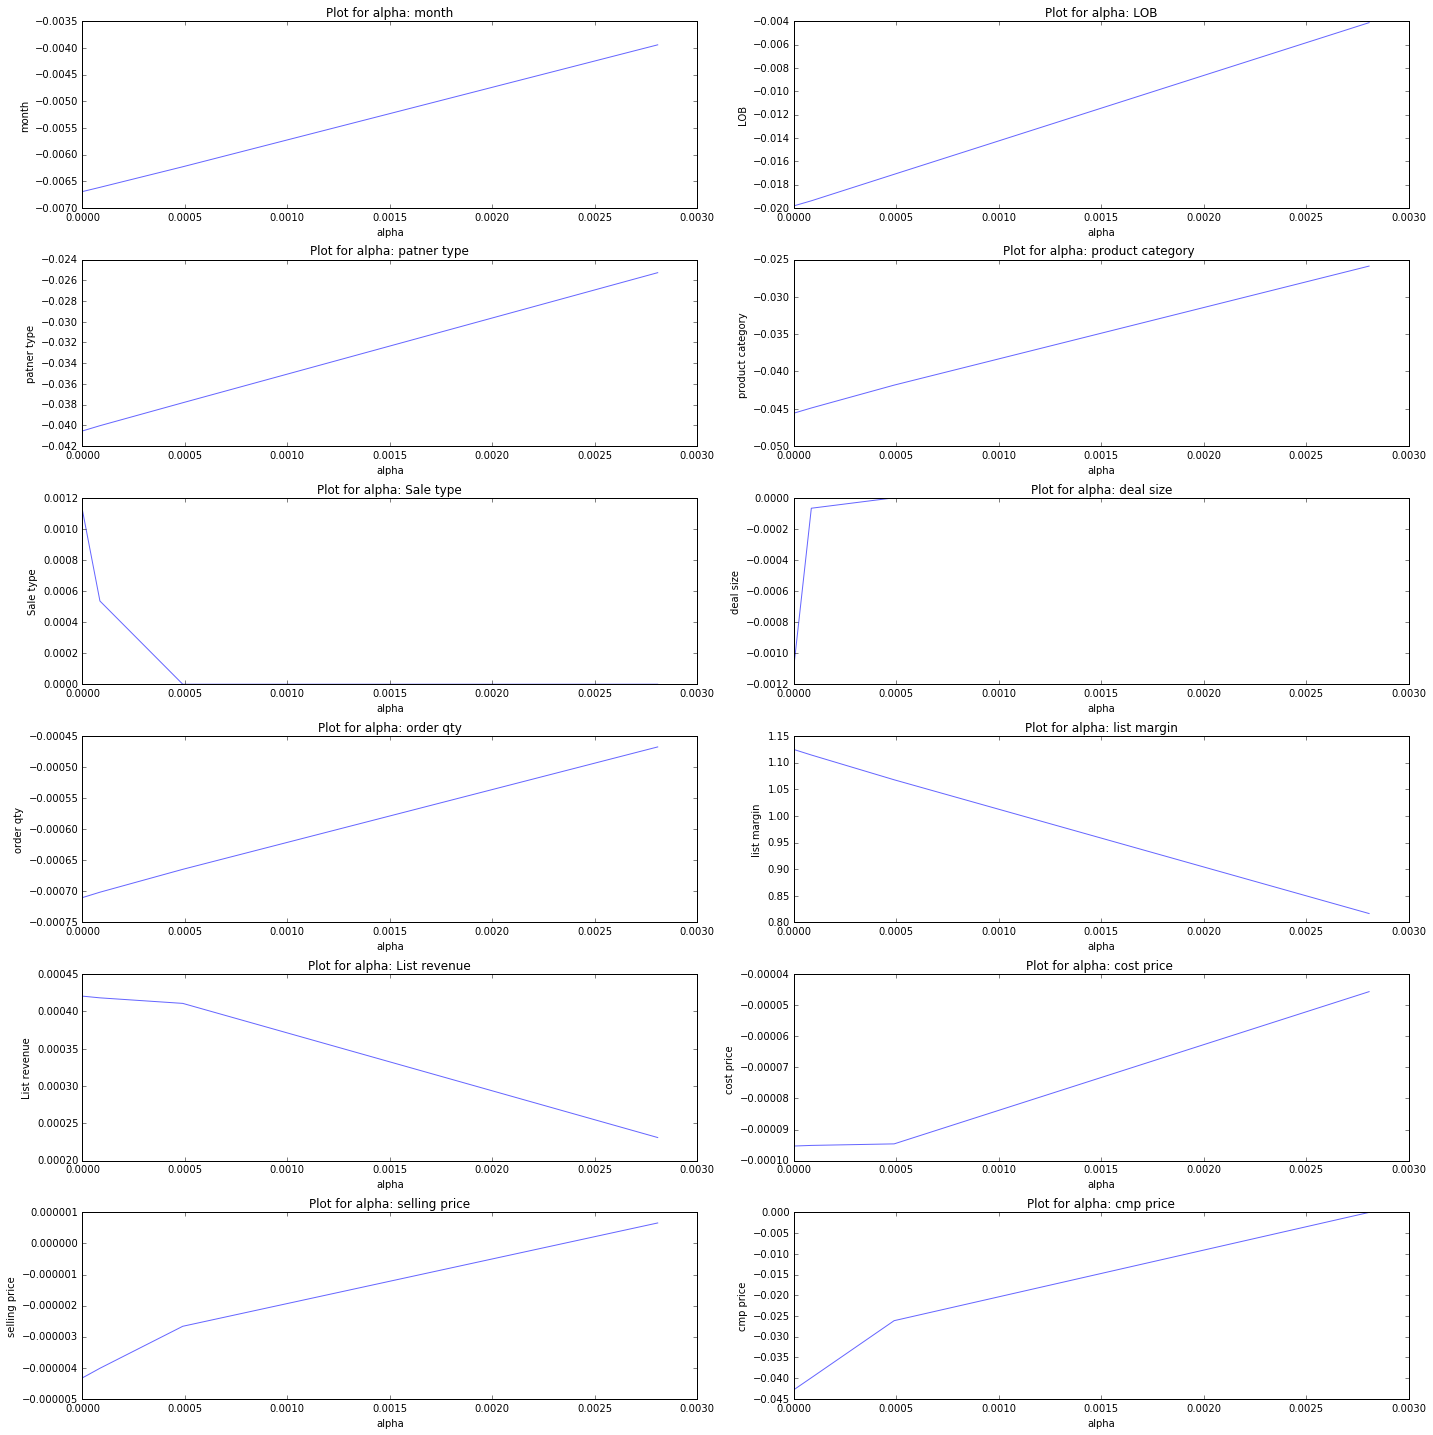

In [179]:
#saveAlphaVsCoeff
#plt.figure(figsize=(50,50))
#print saveAlphaVsCoeff[CustomerDataTempEncoded.columns.values.tolist()].head(5)
#print (CustomerDataTempEncoded.columns.values.tolist())
'''
for val in CustomerDataTempEncoded.columns.values.tolist():
    plt.plot(saveAlphaVsCoeff['alpha'],saveAlphaVsCoeff[val],"--")
    plt.axis([0, 150, -2, 2])
    #plt.legend(CustomerDataTempEncoded.columns.values.tolist(),loc=2)
    plt.legend(CustomerDataTempEncoded.columns.values.tolist(),
           bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    plt.ylabel("Coeff")
    plt.xlabel("alpha")
'''
f,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8), (ax9,ax10),(ax11,ax12))=plt.subplots(6,2,figsize=(20, 20))
axis = [ax1, ax2, ax3, ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]
# filter out list margin non-zeros
tmp = saveAlphaVsCoeff[saveAlphaVsCoeff['list margin' ] != 0]

for oindex,oval in enumerate(CustomerDataTempEncoded.columns.values.tolist()):
    #plt.subplot(val)
    #axis[oindex].axis([0, 150, -2, 2])
    axis[oindex].plot(tmp['alpha'],tmp[oval],alpha=.6)
    #plt.plot(data['x'],data['y'],'.')
    axis[oindex].set_title('Plot for alpha: {}'.format(oval))
    axis[oindex].set_xlabel('alpha')
    axis[oindex].set_ylabel(oval)
    
plt.tight_layout()
plt.savefig('all_Lasso_test_plot.png', dpi=300)

# Let's try to see if solution predicts correct
#### Let's not filter out features though few of the like 'list revenue', 'cost price', 'selling price', 'cmp price' can be removed as of now.
#### Later we will try removing it also 

In [180]:
# Let's normalize all the values
featuresToNormalize = ['order qty', 'list margin', 'List revenue', 'cost price ', 'selling price', 'cmp price']
featuresToNormalizeAll = featuresToNormalize
CustomerDataTempEncodedNormalized = CustomerDataTempEncoded
CustomerDataTempEncodedNormalized[featuresToNormalize], featuresNorms = normalize_features(CustomerDataTempEncoded[featuresToNormalize])

DiscountNormalized, discNorm = normalize_features(Discount)

In [181]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(CustomerDataTempEncodedNormalized,
                                                    DiscountNormalized, 
                                                    test_size=0.20, 
                                                    random_state=42)

In [182]:
'''X_train, X_validation, y_train, y_validation = train_test_split(X_train,
                                                    y_train, 
                                                    test_size=0.20, 
                                                    random_state=42)
'''

'X_train, X_validation, y_train, y_validation = train_test_split(X_train,\n                                                    y_train, \n                                                    test_size=0.20, \n                                                    random_state=42)\n'

In [183]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=60,weights='distance')
neigh.fit(X_train, y_train) 
predicatedDiscount = neigh.predict(X_test)

#print (predicatedDiscount*discountNorm, y_validation*discountNorm)
residualSum = sum((predicatedDiscount-y_test)**2)
print (residualSum)

0.0124939766823


In [270]:
from sklearn.metrics import r2_score
from sklearn import grid_search
# Set the parameters by cross-validation
tuned_parameters = [{'weights': ['uniform'], 
                     'n_neighbors': [10,12,15,18,20,22,25,28,30,40,50,60,70,80,90], 
                     'leaf_size' : [10,20,30,40,50]}]
score = 'r2'
clf = grid_search.GridSearchCV(KNeighborsRegressor(), tuned_parameters, cv=5,
                   scoring=score)
clf.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [10, 12, 15, 18, 20, 22, 25, 28, 30, 40, 50, 60, 70, 80, 90], 'weights': ['uniform'], 'leaf_size': [10, 20, 30, 40, 50]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='r2', verbose=0)

In [285]:
print("Best params :{}".format(clf.best_params_))
predicatedDiscount = clf.predict(X_test)

#print (predicatedDiscount*discountNorm, y_validation*discountNorm)
residualSum = sum((predicatedDiscount*discNorm-y_test*discNorm)**2)
print ("RSS: {}".format(residualSum))

Best params :{'n_neighbors': 28, 'weights': 'uniform', 'leaf_size': 30}
RSS: 209.970275213


In [184]:
columnsPredTable = CustomerDataTempEncodedNormalized.columns.values.tolist()
columnsPredTable.append('Discount')
columnsPredTable.append('Predicted Discount')


In [303]:
#print (saveAlphaVsCoeff.columns)
featuresToNormalize
columnsPredDF = pd.DataFrame(columns=columnsPredTable)
columnsPredDF = X_test
columnsPredDF[featuresToNormalize] = X_test[featuresToNormalize]*featuresNorms
columnsPredDF['Discount'] = y_test*discNorm
columnsPredDF['Predicted Discount'] = predicatedDiscount*discNorm

columnsPredDF.head(5)

C:\Users\Dikshit\Anaconda4\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Dikshit\Anaconda4\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,month,LOB,patner type,product category,Sale type,deal size,order qty,list margin,List revenue,cost price,selling price,cmp price,Discount,Predicted Discount
4352,1,0,2,3,0,1,1,0.266163,56.430,139.995,228.645,0,0.110004,0.071339
38419,10,3,2,1,0,0,1,0.391347,0.000,0.000,0.000,0,0.199993,0.221370
38489,11,3,2,1,1,1,1,0.383293,0.000,0.000,0.000,0,0.269447,0.262448
35831,4,3,0,1,0,1,1,0.351455,0.000,0.000,0.000,0,0.183746,0.221815
22760,2,2,2,2,0,0,1,0.413881,71.605,294.995,364.500,0,0.000048,0.140235


# Let's remove few features and try

In [185]:
from sklearn.cross_validation import train_test_split
featuresSelected = ['month','LOB','patner type','product category ','Sale type',
                    'deal size','order qty','list margin']
X_train, X_test, y_train, y_test = train_test_split(CustomerDataTempEncodedNormalized[featuresSelected],
                                                    DiscountNormalized, 
                                                    test_size=0.20, 
                                                    random_state=42)

In [ ]:
print (featuresToNormalize)
print (featuresNorms)
from sklearn.metrics import r2_score
from sklearn import grid_search
# Set the parameters by cross-validation
tuned_parameters = [{'weights': ['uniform'], 
                     'n_neighbors': [10,12,15,18,20,22,25,28,30,40,50,60,70,80,90], 
                     'leaf_size' : [10,20,30,40,50]}]
score = 'r2'
clf = grid_search.GridSearchCV(KNeighborsRegressor(), tuned_parameters, cv=5,
                   scoring=score)
clf.fit(X_train, y_train)

In [ ]:
print("Best params :{}".format(clf.best_params_))
predicatedDiscount = clf.predict(X_test)

#print (predicatedDiscount*discountNorm, y_validation*discountNorm)
residualSum = sum((predicatedDiscount*discNorm-y_test*discNorm)**2)
print ("RSS: {}".format(residualSum))

In [ ]:
columnsPredTable = CustomerDataTempEncodedNormalized.columns.values.tolist()
columnsPredTable.append('Discount (%)')
columnsPredTable.append('Predicted Discount (%)')
featuresSelected

#featuresToNormalize.remove(featuresSelected[-2:])
#featuresToNormalize.remove('')
columnsPredDF = pd.DataFrame(columns=columnsPredTable)
columnsPredDF = X_test
columnsPredDF[featuresToNormalize[0:2]] = X_test[featuresToNormalize[0:2]]*featuresNorms[0:2]
columnsPredDF['Discount (%)'] = y_test*discNorm*100 
columnsPredDF['Predicted Discount (%)'] = predicatedDiscount*discNorm*100

columnsPredDF.head(5)

In [333]:
print (featuresToNormalizeAll)
print (featuresSelected)


['order qty', 'list margin', 'List revenue', 'cost price ', 'selling price', 'cmp price']
['month', 'LOB', 'patner type', 'product category ', 'Sale type', 'deal size', 'order qty', 'list margin']


count    40188.000000
mean         0.154828
std          0.107997
min         -4.800000
25%          0.100003
50%          0.140002
75%          0.207744
max          6.400000
Name: Discount, dtype: float64


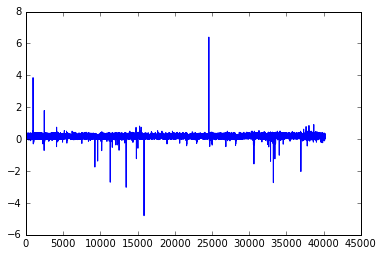

In [131]:
print (CustomerDataTemp['Discount'].describe())
#plt.plot(CustomerDataTemp['Discount'])
plt.plot(CustomerDataTemp['Discount'])

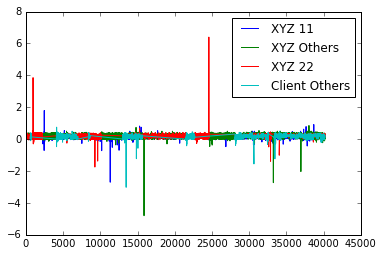

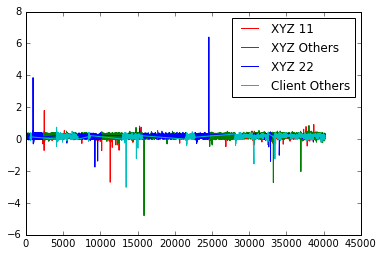

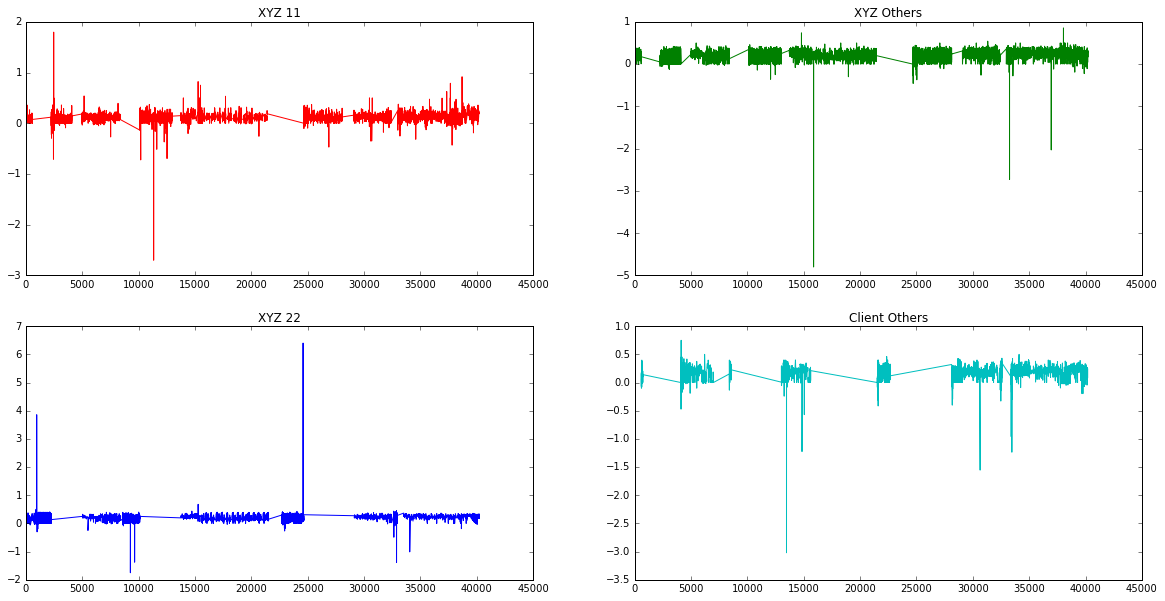

In [151]:
plt_legend = []
colormap='rgbc'
for index,val in enumerate(CustomerDataTemp['product category '].unique()):
    plt.plot(CustomerDataTemp[CustomerDataTemp['product category '] == val]['Discount'], color=colormap[index])
    plt_legend.append(val)
    
plt.legend(plt_legend)

f,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(20, 10))
axis = [ax1, ax2, ax3, ax4]
prodCategoryDescribe = pd.DataFrame(columns=['Product Category','min','max','mean','count'])
for index,val in enumerate(CustomerDataTemp['product category '].unique()):
    #print (index,val)
    prodCategory = CustomerDataTemp[CustomerDataTemp['product category '] == val]['Discount']
    axis[index].plot(prodCategory, color=colormap[index])
    axis[index].set_title(val)
    _prodDes = prodCategory.describe()
    prodCategoryDescribe.loc[index] = [val,_prodDes['min'], _prodDes['max'],_prodDes['mean'],_prodDes['count']]

In [152]:
prodCategoryDescribe

,Product Category,min,max,mean,count
0,XYZ 11,-2.699969,1.796064,0.109671,11185.0
1,XYZ Others,-4.800000,0.854450,0.196056,13406.0
2,XYZ 22,-1.749969,6.400000,0.162654,9726.0
3,Client Others,-3.019996,0.749469,0.133754,5871.0


          order qty      Discount   list margin  List revenue   cost price   \
count  39346.000000  39346.000000  39346.000000  39346.000000  39346.000000   
mean       2.885528      0.152529      0.307098     57.074662    193.240487   
std        5.422813      0.083776      0.087967     74.636439    299.410689   
min        1.000000     -0.060217     -1.579661      0.000000      0.000000   
25%        1.000000      0.100002      0.226201     11.600000     37.495000   
50%        1.000000      0.139989      0.331141     41.295000    102.495000   
75%        2.000000      0.201038      0.378899     73.220000    242.495000   
max      115.000000      0.369323      1.100000    929.525000   4004.995000   

       selling price     cmp price  
count   39346.000000  39346.000000  
mean      213.372959      0.072797  
std       340.697913      0.220393  
min         0.000000      0.000000  
25%         0.000000      0.000000  
50%       130.400000      0.000000  
75%       267.360000      0.0

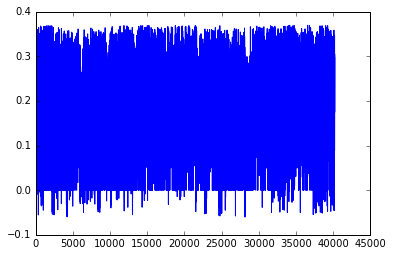

In [85]:
print (CustomerDataRemovedMissingAndOL.describe())
plt.plot(CustomerDataRemovedMissingAndOL['Discount'])

{'boxes': [<matplotlib.lines.Line2D at 0x7f94fab5c2b0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f94fab3bcc0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f94fb0f9e48>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f94fb0f9630>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f94fab5cc50>,
  <matplotlib.lines.Line2D at 0x7f94fab5cd68>]}

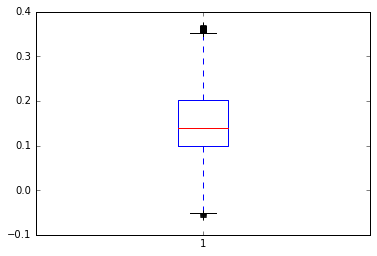

In [74]:
plt.boxplot(CustomerDataRemovedMissingAndOL['Discount'])

In [75]:
import numpy as np
from scipy import cluster
from matplotlib import pyplot

        month  LOB patner type product category  Sale type deal size  \
590  2015-M10  CSB           V     Client Others       POS     Small   
591  2015-M11  CSB           D     Client Others      APOS     Small   
592  2015-M11  CSB           D     Client Others       POS       big   
593  2015-M11  CSB           V     Client Others      APOS     Small   
594  2015-M12  CSB           V     Client Others      APOS     Small   

     order qty  Discount  list margin  List revenue  cost price   \
590          1  0.150030     0.348266          0.00        0.000   
591          1 -0.070298     0.311406         53.81      139.995   
592          2  0.175311     0.302105         56.43      139.995   
593          2 -0.088604     0.300882         53.81      139.995   
594          1  0.000012     0.285113         56.43      139.995   

     selling price  cmp price  
590          0.000        0.0  
591        228.645        0.0  
592        228.645        0.0  
593        228.645        0.0 

/home/tivo/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


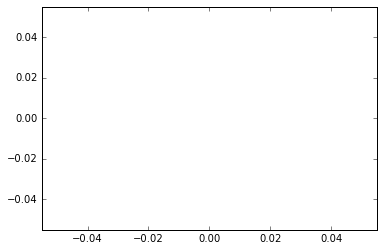

In [84]:

groups = CustomerDataTemp.groupby('product category ')

# Plot
fig, ax = plt.subplots()
#print (groups.head())
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    print (group.head(5))
    #ax.plot(group['patner type'], group['Discount'], marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()
#plt.scatter(CustomerDataTemp['Discount'])